In [288]:
from jaxgp.predict import full_predict
from jax import random

from jaxopt import ScipyBoundedMinimize
import jax.numpy as jnp

import matplotlib.pyplot as plt

import jax

## Acquisition function

In [289]:
grid = jnp.linspace(0,2*jnp.pi, 200)

In [290]:
def upper_confidence_bound(cov_matrix, Y_data, X_split, kernel, params, bounds, eval_function):
    # def minim_func(x):
    #     mean, std = full_predict(x, cov_matrix, Y_data, X_split, kernel, params)
    #     return -(std[0])
    
    # key = random.PRNGKey(0)
    # init_point = random.uniform(key, shape=bounds[0].shape, minval=bounds[0], maxval=bounds[1]).reshape(1,-1)
    
    # solver = ScipyBoundedMinimize(fun=minim_func, method="L-BFGS-B")
    # result = solver.run(init_point, bounds)

    # X_next = result.params
    # Y_next, isgrad = eval_function(X_next)

    mean, std = jax.jit(full_predict)(grid.reshape(-1,1), cov_matrix, Y_data, X_split, kernel, params)

    next_arg = jnp.argmax((mean + 10*std).reshape(-1))
    X_next = grid[next_arg]
    Y_next, isgrad = eval_function(X_next)

    fig, ax = plt.subplots(1,2)
    ax[0].plot(grid, mean, label="predict")
    ax[0].fill_between(grid, (mean-std).reshape(-1), (mean+std).reshape(-1), alpha=0.5)
    for elem in X_split[1]:
        ax[0].axvline(elem, c="r")
    ax[1].plot(grid, (mean + 10*std).reshape(-1), label="acqui")
    ax[1].axvline(X_next)


    return X_next, Y_next.reshape(-1), isgrad

In [291]:
from dataclasses import dataclass
from typing import Callable, Tuple, Union

import jax
import jax.numpy as jnp
from jax.numpy import ndarray
from jaxopt import ScipyBoundedMinimize

from jaxgp.covar import full_covariance_matrix
from jaxgp.kernels import BaseKernel
from jaxgp.likelyhood import full_kernelNegativeLogLikelyhood

from jax.tree_util import register_pytree_node_class

import time

def _bayesoptstep(X_split: Tuple[ndarray, ndarray], Y_data: Tuple[ndarray, ndarray], init_params: ndarray, kernel: BaseKernel, 
                  noise: Union[float, ndarray], acquisition_func: Callable, *args) -> ndarray:
    '''_summary_

    Parameters
    ----------
    X_split : Tuple(ndarray, ndarray)
        _description_
    Y_data : Tuple(ndarray, ndarray)
        _description_
    init_params : ndarray
        _description_
    kernel : BaseKernel
        _description_
    noise : Union[float, ndarray]
        _description_
    optimize_method : str
        _description_
    acquisition_func : Callable
        A function that takes the model as input and return the "best" next point to add to the model, i.e.
        model -> (X_next, Y_next / grad(Y_next), isgrad)
    args : Any
        Additional arguments for acquisition_func

    Returns
    -------
    ndarray
        _description_
    '''
    solver = ScipyBoundedMinimize(fun=full_kernelNegativeLogLikelyhood)
    result = solver.run(init_params, (1e-3,jnp.inf), X_split, jnp.hstack(Y_data), noise, kernel)

    cov_matrix = jax.jit(full_covariance_matrix)(X_split, noise, kernel, result.params)

    X_next, Y_next, isgrad = acquisition_func(cov_matrix, jnp.hstack(Y_data), X_split, kernel, result.params, *args)

    if isgrad:
        X_next = (X_split[0], jnp.vstack((X_split[1], X_next)))
        Y_next = (Y_data[0], jnp.hstack((Y_data[1], Y_next)))
    else:
        X_next = (jnp.vstack((X_split[0], X_next)), X_split[1])
        Y_next = (jnp.hstack((Y_data[0], Y_next)), Y_data[1])
        
    return (X_next, Y_next)

def _randomstep(X_split: Tuple[ndarray, ndarray], Y_data: Tuple[ndarray, ndarray], bounds, eval_func) -> ndarray:
    '''_summary_

    Parameters
    ----------
    X_split : Tuple(ndarray, ndarray)
        _description_
    Y_data : Tuple(ndarray, ndarray)
        _description_
    bounds:

    Returns
    -------
    ndarray
        _description_
    '''
    key = random.PRNGKey(int(time.time()))
    X_next = random.uniform(key, shape=bounds[0].shape, minval=bounds[0], maxval=bounds[1]).reshape(1,-1)
    Y_next, isgrad = eval_func(X_next)
    Y_next = Y_next.reshape(-1)

    if isgrad:
        X_next = (X_split[0], jnp.vstack((X_split[1], X_next)))
        Y_next = (Y_data[0], jnp.hstack((Y_data[1], Y_next)))
    else:
        X_next = (jnp.vstack((X_split[0], X_next)), X_split[1])
        Y_next = (jnp.hstack((Y_data[0], Y_next)), Y_data[1])
        
    return (X_next, Y_next)

@dataclass   
class BayesOpt:
    X_split: Tuple[ndarray, ndarray]
    Y_train: ndarray
    kernel: BaseKernel
    init_kernel_params: ndarray
    noise: Union[float, ndarray]
    acquisition_func: Callable
    acqu_extra_args: Tuple

    # def __post_init__(self):
    #     self.result = (self.X_split, self.Y_train)

    def run(self, num_iters: int) -> None:
        X, Y = self.X_split, self.Y_train

        for i in range(num_iters):
            if i%2 == 0:
                X, Y = _randomstep(X, Y, *self.acqu_extra_args)
            else:
                X, Y = _bayesoptstep(X, Y, self.init_kernel_params, self.kernel, self.noise, self.acquisition_func, *self.acqu_extra_args)

        self.X_split, self.Y_train = X, Y

        # result = (self.X_split, self.Y_train)
        # def for_body(i, input):
        #     return _bayesoptstep(*input, self.init_kernel_params, self.kernel, self.noise, self.acquisition_func, *self.acqu_extra_args)
        
        # self.X_split, self.Y_train = jax.lax.fori_loop(0, num_iters, for_body, result)

In [292]:
# true function is a noisy lennard jones potential
def sin(x, noise=0.0, key = random.PRNGKey(0)):
    return jnp.sin(x) + random.normal(key,x.shape, dtype=jnp.float32)*noise

def cos(x, noise=0.0, key = random.PRNGKey(0)):
    return jnp.cos(x) + random.normal(key,x.shape, dtype=jnp.float32)*noise

To define the training data we first need to define boundaries to choose the datapoints from. Then, random points are chosen in this interval. `random.split` creates a new subkey from the previous key to get a new sudo-random sample from the uniform distribution.

In [293]:
# Interval bounds from which to choose the data points
bounds = jnp.array([0.0, 2*jnp.pi])

# How many function and derivative observations should be chosen
num_f_vals = (1,)
num_d_vals = (3,)

# initial seed for the pseudo random key generation
seed = 0

# create new keys and randomly sample the above interval for training features
key, subkey = random.split(random.PRNGKey(seed))
x_func = random.uniform(subkey, num_f_vals, minval=bounds[0], maxval=bounds[1])
key, subkey = random.split(key)
x_der = random.uniform(subkey, num_d_vals, minval=bounds[0], maxval=bounds[1])

# noise with which to sample the training labels
noise = 0.1
key, subkey = random.split(key)
y_func = sin(x_func,noise, subkey)
key, subkey = random.split(key)
y_der = cos(x_der, noise, subkey)

The GPR framework needs as input for training a tuple of arrays `X_split` of which contains a set of points where the function is sampled and a set of points where the gradient is sampled. Both array in `X_split` is of shape `(n_samples_i, N)`. `X_split` should be ordered as follows: the first array represents the datapoints for the function observations and the second array represents the gradient of the function. `Y_train` should just be an array of shape `(n_samples_function + n_samples_gradient,)`.

In [294]:
# reshaping needs to be done the get the arrays in the form (n_samples_i, N)
X_split = [x_func.reshape(-1,1),x_der.reshape(-1,1)]

Y_train = (y_func, y_der) # jnp.hstack((y_func, y_der))

In [295]:
print(X_split[1].shape)

(3, 1)


### Defining the Kernel and its initial parameters

The kernels can be found in `jaxgp.kernels`. Currently implemented are `RBF`, `Linear`, and `Periodic` kernels. When in doubt what kernel to use, go with an `RBF` kernel.

In [296]:
from jaxgp.kernels import RBF

kernel = RBF()
# an RBF kernel has per default 2 parameters
init_kernel_params = jnp.array([2.0, 2.0])

In [297]:
bounds = jnp.array([0.0,2*jnp.pi])
eval_func = lambda x: (cos(x, noise, key), True)
extra_args = (bounds, eval_func)

model = BayesOpt(X_split, Y_train, kernel, init_kernel_params, noise, upper_confidence_bound, extra_args)

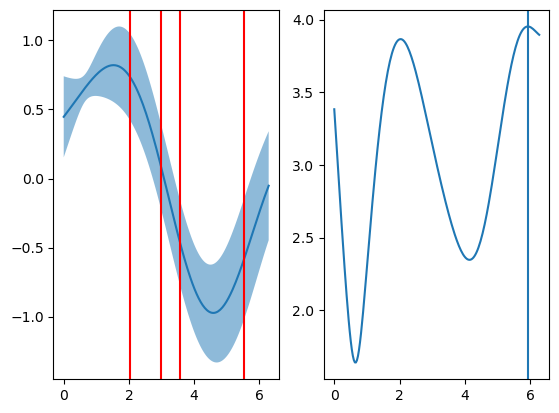

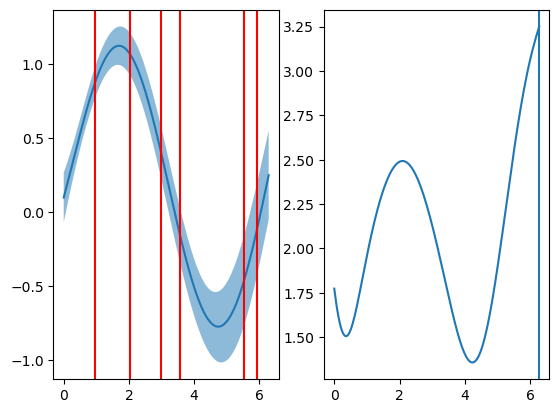

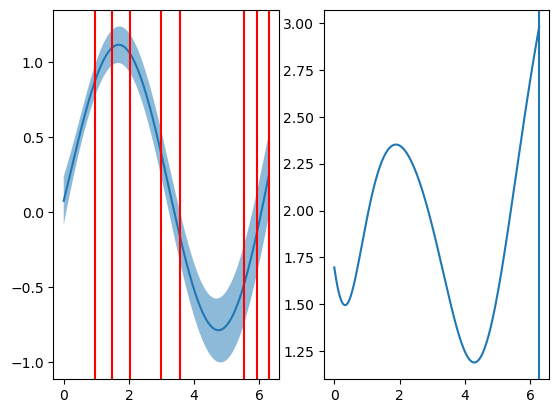

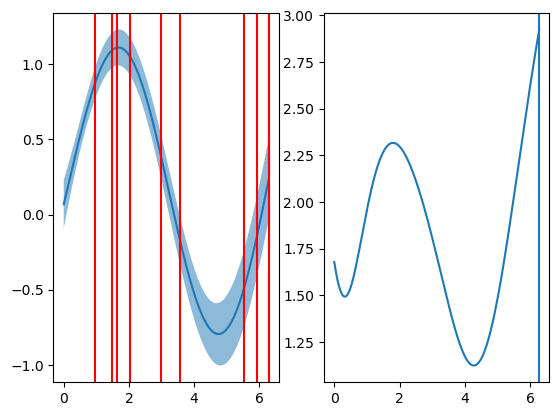

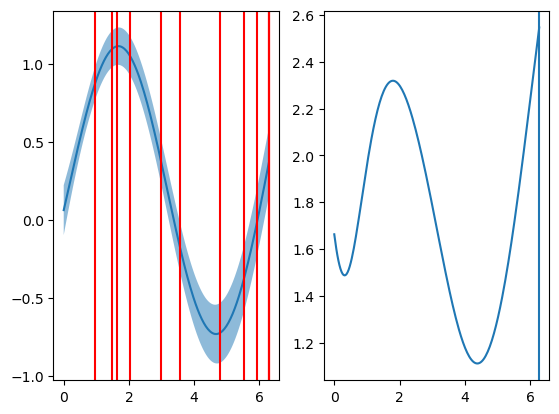

In [298]:
model.run(10)